<h1 align='center'>NBA SUPERVISED LEARNING CAPSTONE</h1>
<h2 align='center'>Philip Bowman</h2>

## Part 3: NBA Modeling
1. [NBA Data Aggregation](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/supervised_capstone/Jupyter%20Notebooks/Data_Aggregation.ipynb)
2. [NBA Data Cleaning and Exploration](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/supervised_capstone/Jupyter%20Notebooks/Data_Cleaning_Exploration.ipynb)
3. [NBA Modeling](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/supervised_capstone/Jupyter%20Notebooks/Modeling.ipynb)*
4. [NBA Model Testing](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/supervised_capstone/Jupyter%20Notebooks/Model_Testing.ipynb)

## Purpose:

To create and test machine learning models to predict the winner of a modern NBA game. This will be done by using the features engineered in the prior notebook (see [NBA Data Cleaning and Exploration](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/supervised_capstone/Jupyter%20Notebooks/Data_Cleaning_Exploration.ipynb)). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Holdouts and Validation Sets

The data will be split into a holdout set, validation set and training set. The holdout set will be used for final predictions (on this dataset), think of it as a final grade for the models presented. The validation set will test how well a model performs on a small unseen set of data, think of it as the midterm grade. While the training set will be used to create models, think of this as homework in preparation for the midterm and final. This small section will get all those datasets (and their variants) in order.

Import the feature set.

In [2]:
df = pd.read_csv('C:/Users/philb/Google Drive/Thinkful/Thinkful_repo/projects/supervised_capstone/Export Data/target_features.csv', index_col=0)

Seperate the target and the features.

In [3]:
target = df.iloc[:, 0]
features = df.iloc[:, 1:]

Use `train_test_split()` to create the holdout sets (`X_holdout`/`y_holdout`), validation sets (`X_test`/`y_test`), and training sets (`X_train`/`y_train`).

In [4]:
X, X_holdout, y, y_holdout = train_test_split(features, target, test_size=.2, random_state=795)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=795)

Create a few scalers as different models have different requirements of thier data. `StandardScaler` and `MinMaxScaler` are used here as the `StandardScaler` will help in models that have trouble with larger values and `MinMaxScaler` will help when datasets must have only positive numbers.

In [5]:
sscaler = StandardScaler() 
mmscaler = MinMaxScaler() 

Standardized (x - mean / std) data is created and Min Maxed (0-1) data is created, note here that the first column is not standardized as it is a categorical variable (`teamHome_A`). The data is transformed in such a way that the training data is fit to the scaler then transformed, but the validation/test set is not part of the scaler's fitting and is only transformed based off of the training set's fit.

In [6]:
s_train = pd.DataFrame(sscaler.fit_transform(X_train.iloc[:, 1:]), columns=X_train.columns[1:], index=X_train.index).join(X_train.iloc[:, 0]).copy()
s_test = pd.DataFrame(sscaler.transform(X_test.iloc[:, 1:]), columns=X_test.columns[1:], index=X_test.index).join(X_test.iloc[:, 0]).copy()

In [7]:
mm_train = pd.DataFrame(mmscaler.fit_transform(X_train.iloc[:, 1:]), columns=X_train.columns[1:], index=X_train.index).join(X_train.iloc[:, 0]).copy()
mm_test = pd.DataFrame(mmscaler.transform(X_test.iloc[:, 1:]), columns=X_test.columns[1:], index=X_test.index).join(X_test.iloc[:, 0]).copy()

This function's purpose is to easily display information in the data selection stage.

In [8]:
def ck_cvs(model):
    base_scores= cross_val_score(model, X_train, y_train, n_jobs=-1)
    s_scores = cross_val_score(model, s_train, y_train, n_jobs=-1)
    mm_scores = cross_val_score(model, mm_train, y_train, n_jobs=-1)
    model_len = len(str(model).split('(')[0] + ' Data Selection')
    
    print('-'*model_len)
    print(str(model).split('(')[0] + ' Data Selection')
    print('-'*model_len)
    print('Original Data (X_train)')
    print('Scores: {}'.format(base_scores))
    print('Mean:   {}'.format(base_scores.mean()))
    print('---------------------------')
    print('Standardized Data (s_train)')
    print('Scores: {}'.format(s_scores))
    print('Mean:   {}'.format(s_scores.mean()))
    print('------------------------')
    print('MinMaxed Data (mm_train)')
    print('Scores: {}'.format(mm_scores))
    print('Mean:   {}'.format(mm_scores.mean()))
    if len('-'*model_len) > len('---------------------------'):
        print('-'*model_len)
    else:
        print('---------------------------')

This is a function that conducts a grid search (of a grid that is predefined) and returns information pertinent to our model selection decision making process. It also returns the grid used, the test/validation score and the time total time it took for the grid to complete.

In [9]:
def grid_fit_est_test(grid, train, test):
    start = time.time()
    grid.fit(train, y_train)
    stop = time.time()
    grid_time = stop - start
    test_score = grid.score(test, y_test)
    best_est = grid.best_estimator_
    
    print(best_est)
    print('Training: {}'.format(grid.best_score_))
    print('Testing: {}'.format(test_score))
    print('Grid Time: {}s'.format(grid_time))
    return grid, test_score, grid_time

Create an empty list for tracking the best estimators (from the results of the grid searches).

In [10]:
best_estimators = []
scalers = {}

# The Method and the Models

Before hopping into training the models let's have a quick look at the models that will be used and also explain how each model will be tested.

**THE MODELS**
1. Logistic Regression (L1 and L2)
2. K-Neighbors Classifier (K-Nearest Neighbors)
3. Naive Bayes (Multinomial and Bernoulli)
4. Decision Tree
5. Random Forest
6. Support Vector Machines
7. Gradient Tree Boosting
8. eXtreme Gradient Boosting
9. Extremely Randomized Trees (Extra Trees)

**THE METHOD**

For each of the models above, first the appropriate dataset will be deduced using a simple cross validation of each data type using the base model (the model with its default parameters). Then an initial model will be instantiated for each type of model. For that model a parameters dictionary will be created with relevant tuning parameters. Once the model is created and tuning parameters are selected for that model, it will get put into a new `GridSearchCV` model. The function created above will then use the `GridSearchCV` model and return the relevant information for the model tuning. The model will then be added to the `best_estimators` list for future inspection.

# 1. Logistic Regression

**Quick description:**
Logistic Regression is essentially the classifier brother to linear regression. It uses the logistic function to estimate predictions. It is a relatively simple and fast algorithm. If the data is too complex (with non-linear decisions that should be made), it may not perform especially well.

## Data Selection

Instantiate the basic model and test it on the different datasets (`X_train`, `s_train`, `mm_train`). I think the standardized data will likely do best. `X_train` should probably not even be used since it is important for linear models to have standardized data, but it'll get a chance anyways.

In [11]:
log_reg = LogisticRegression()

In [12]:
ck_cvs(log_reg)

---------------------------------
LogisticRegression Data Selection
---------------------------------
Original Data (X_train)
Scores: [0.82156489 0.78625954 0.79770992 0.78701051 0.80229226]
Mean:   0.7989674241927135
---------------------------
Standardized Data (s_train)
Scores: [0.82538168 0.8101145  0.81965649 0.81852913 0.82425979]
Mean:   0.8195883184963216
------------------------
MinMaxed Data (mm_train)
Scores: [0.82824427 0.79866412 0.81583969 0.81470869 0.82330468]
Mean:   0.8161522926281559
---------------------------------


**The Verdict**: For the case of logistic regression, the scaled data will be used.

In [13]:
scalers['logistic'] = 'standardized'

## Tuning using GridSearchCV

In the case of logistic regression there are a lot of potential parameters to consider. Of them all, the primary ones in question are as follows:
1. L1 or L2 regularization (that is essentially, Ridge or Lasso regression)
2. The solver to use for a given type of regularization (newton-cg, sag, lbfgs, liblinear, saga)
3. The C (coefficient) value or the inverse of the strength of regularization (smaller is stronger regularization)

The following code sets up a L2 Logistic Regression model with the appropriate solvers and a C value ranging from 0 to 5 in .1 increments.

In [14]:
log_reg_l2 = LogisticRegression(penalty='l2', max_iter=1000)
l2_params = {'solver': ('newton-cg', 'sag', 'lbfgs'),
             'C': np.arange(0, 5.1, .1)}
grid_l2 = GridSearchCV(log_reg_l2, l2_params, n_jobs=-1, error_score=0, verbose=5)
best_l2 = grid_fit_est_test(grid_l2, s_train, s_test)
best_estimators.append(best_l2)

Fitting 5 folds for each of 153 candidates, totalling 765 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   29.9s


LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Training: 0.8207340857557398
Testing: 0.7989690721649485
Grid Time: 36.76613426208496s


[Parallel(n_jobs=-1)]: Done 765 out of 765 | elapsed:   36.5s finished


In [15]:
log_reg_l1 = LogisticRegression(penalty='l1', max_iter=1000)
l1_params = {'solver': ('liblinear', 'saga'),
             'C': np.arange(0, 5.1, .1)}
grid_l1 = GridSearchCV(log_reg_l1, l1_params, n_jobs=-1, error_score=0, verbose=5)
best_l1 = grid_fit_est_test(grid_l1, s_train, s_test)
best_estimators.append(best_l1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 102 candidates, totalling 510 fits


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 503 out of 510 | elapsed:   15.6s remaining:    0.1s


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
Training: 0.8218785771050694
Testing: 0.8006872852233677
Grid Time: 16.062070608139038s


[Parallel(n_jobs=-1)]: Done 510 out of 510 | elapsed:   15.8s finished


## Logistic Thoughts
Both L2 and L1 regularized logistic regression appear to have performed relatively well, while also being incredibly fast. This will definitely be one to look out for looking forward.

# 2. K-Neighbors Classifier

**Quick Description:** K-Nearest Neighbors is more of a comparative model than a learner. It basically looks at a given datapoint, finds the k-closest other datapoints and categorizes the given datapoint based off of those. Very simple, but it can also be relatively computationally expensive with large datasets!

## Data Selection

This one should actually perform basically the same regardless of the dataset. The reason for this is because of how KNN works. Let's see.

In [16]:
knn_clf = KNeighborsClassifier(n_jobs=-1)

In [17]:
ck_cvs(knn_clf)

-----------------------------------
KNeighborsClassifier Data Selection
-----------------------------------
Original Data (X_train)
Scores: [0.64408397 0.63645038 0.65839695 0.62464183 0.61318052]
Mean:   0.6353507294560249
---------------------------
Standardized Data (s_train)
Scores: [0.71851145 0.71660305 0.71374046 0.72301815 0.70200573]
Mean:   0.7147757679156004
------------------------
MinMaxed Data (mm_train)
Scores: [0.76908397 0.73377863 0.76145038 0.74498567 0.747851  ]
Mean:   0.7514299306634002
-----------------------------------


Turns out I was wrong, it worked the best on the min maxed data, interesting.

**The Verdict:** Min maxed data performed the best using the base algorithm, so it'll be the one used in the parameter tuning.

In [18]:
scalers['knn'] = 'minmaxed'

## Tuning Parameters

Tuning for K-Nearest Neighbors is relatively simple in comparison to Logistic regression. Ultimately it comes down to how many neighbors you want to use for voting and also how you want to measure the distance between two points (which is likely why the min maxed dataset performed the best). So, 'n_neighbors' goes through 1 to 30 neighbors and 'p' cycles through different distance metrics (manhattan for p=1; euclidean for p=2; and minkowski for p=3,4).

In [19]:
knn_params = {'n_neighbors': np.arange(1, 31, 1),
              'p': np.arange(1, 5, 1)}

In [20]:
grid_knn = GridSearchCV(knn_clf, knn_params, n_jobs=-1, error_score=0, verbose=5)

In [21]:
best_knn = grid_fit_est_test(grid_knn, mm_train, mm_test)
best_estimators.append(best_knn)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  5.9min finished


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=28, p=1,
                     weights='uniform')
Training: 0.7869403311533498
Testing: 0.7783505154639175
Grid Time: 352.3201186656952s


## KNN Thoughts

This classifier performed relatively well. It does take a much longer time to train, however. And if the amount of data gets larger it will only take longer to perform its operations. This could be a good estimator in the right situations. But I'm thinking it isn't going to fit the bill in this case.

# 3. Naive Bayes Estimators

**Quick Description:** Naive Bayes is all about probability and Bayes' theorem. It has a number of assumptions, perhaps the most stringent of which is that its features are assumed to be independent of one another. Even with this assumption, Naive Bayes is used a lot due to its simplicity, speed and relative flexibility. It likely won't have the best results in this case, but it's worth looking into.

## Data Selection

For Naive Bayes, both Multinomial and Bernoulli (binary) forms will be explored. In the case of Bernoulli, it would make no sense to use anything other than the X_train data as the model will binarize (change it to 0's and 1's) its inputs before training. Also if we used the standardized data, if anything was actually equal to the mean, its value could wrongly be 0. Similarly with the min-maxed data, the lowest values will be 0 (when they may not actually be zero), this also would cause problems. In the case of the Multinomial form it actually only makes sense to use the min-maxed data as negatives will not work when used with Multinomial Naive Bayes. Unfortunately, this means that any minimums become zero in this case. I don't think there is a lot of hope for Multinomial Naive Bayes in this particular situation. 

**The Verdict:** Multinomial Naive Bayes will use min-maxed data and the Bernoulli model will use the base data (X_train).

In [22]:
scalers['multi_nb'] = 'minmaxed'
scalers['bern_nb'] = 'base'

## Tuning Parameters

The only one to really tune here is alpha (the smoothing parameter) for both situations.

In [23]:
nbm_clf = MultinomialNB()
nbb_clf = BernoulliNB()

In [24]:
nb_params = {'alpha': np.arange(0.0000000001, 5.1, 1)}

In [25]:
grid_nbm = GridSearchCV(nbm_clf, nb_params, n_jobs=-1, verbose=5)

In [26]:
best_nbm = grid_fit_est_test(grid_nbm, mm_train, mm_test)
best_estimators.append(best_nbm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


MultinomialNB(alpha=1e-10, class_prior=None, fit_prior=True)
Training: 0.7604023126781717
Testing: 0.761168384879725
Grid Time: 0.5793650150299072s


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished


In [27]:
grid_nbb = GridSearchCV(nbb_clf, nb_params, n_jobs=-1, verbose=5)

In [28]:
best_nbb = grid_fit_est_test(grid_nbb, X_train, X_test)
best_estimators.append(best_nbb)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.4s remaining:    0.1s


BernoulliNB(alpha=1e-10, binarize=0.0, class_prior=None, fit_prior=True)
Training: 0.7462756184518472
Testing: 0.7405498281786942
Grid Time: 0.6238460540771484s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished


## Naive Bayes Thoughts
Perhaps the most interesting thing to come from the above is the fact that just the binarized values alone were able to return a pretty solid accuracy statistic. This will likely be one of the worst classifiers, but likely one of the fastest as well. Was worth a try.

# 4. Decision Tree

**Quick Description:** A simple and very descriptive model. Basically this model splits determination into the biggest decision at each "branch" of a tree. Based off that, it then determines the class (based off the number of classes down each branch in the case of classification).

## Data Selection

This one should be relatively similar regardless of what is thrown at it. Let's test that theory.

In [29]:
dt_clf = DecisionTreeClassifier()

In [30]:
ck_cvs(dt_clf)

-------------------------------------
DecisionTreeClassifier Data Selection
-------------------------------------
Original Data (X_train)
Scores: [0.75763359 0.73950382 0.73187023 0.73161414 0.73925501]
Mean:   0.7399753567080061
---------------------------
Standardized Data (s_train)
Scores: [0.75954198 0.73950382 0.72041985 0.7382999  0.72110793]
Mean:   0.735774696151126
------------------------
MinMaxed Data (mm_train)
Scores: [0.75572519 0.73473282 0.73473282 0.73161414 0.72397326]
Mean:   0.7361556464489599
-------------------------------------


**The Verdict:** Depending on the run, any one of these can be the best, we'll stick with standardized here.

In [31]:
scalers['decision tree'] = 'standardized'

## Parameter Tuning

Pretty basic tuning here as well. How deep should the tree go? And what criteria do we use, Gini Impurity or Entropy?

In [32]:
dt_params = {'max_depth': np.arange(1, 16, 1), 
             'criterion': ('gini', 'entropy')}

In [33]:
grid_dt = GridSearchCV(dt_clf, dt_params, n_jobs=-1, verbose=5)

In [34]:
best_dt = grid_fit_est_test(grid_dt, s_train, s_test)
best_estimators.append(best_dt)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:    6.4s remaining:    0.2s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Training: 0.8151977296091341
Testing: 0.7903780068728522
Grid Time: 7.174255609512329s


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.9s finished


That also performed relatively well. It looks like a lower max depth worked better when it came to accuracy and the gini criteria worked better.

## Decision Tree Thoughts

Turns out that this method works surprisingly well. Having one of the better testing/validation scores so far. Also executes very quickly.

# 5. Random Forest

**Quick Description:** What if a bunch of decision trees are thrown together and you take the average of them all? Well, then you have a forest. A wonderful ensemble method which bags a bunch of randomly generated trees together. This takes the potential for overfitting from Decision Trees and minimizes it.

## Data Selection

Similar to decision trees this could probably go any way, I'm thinking standardized is probably going to do best here based on the decision trees above.

In [35]:
rf_clf = RandomForestClassifier(n_jobs=-1)

In [36]:
ck_cvs(rf_clf)

-------------------------------------
RandomForestClassifier Data Selection
-------------------------------------
Original Data (X_train)
Scores: [0.83587786 0.80152672 0.78912214 0.80802292 0.81279847]
Mean:   0.809469622403523
---------------------------
Standardized Data (s_train)
Scores: [0.82919847 0.79198473 0.80343511 0.80802292 0.8156638 ]
Mean:   0.8096610089167889
------------------------
MinMaxed Data (mm_train)
Scores: [0.82633588 0.79961832 0.80534351 0.80897803 0.81088825]
Mean:   0.8102327989092792
-------------------------------------


Looks like that is indeed the case.

**The Verdict:** Depending on how the forest randomizes, this could be any one of the above, we'll stick with standardized here as well.

In [37]:
scalers['random forest'] = 'standardized'

## Parameter Tuning

Similar to decision trees above we need to determine the criteria for the trees (gini or entropy) as well as the max depth. But, new in this method is the number of estimators, which basically equates to the number of trees in the forest.

In [38]:
rf_params = {'criterion': ('gini', 'entropy'),
             'max_depth': np.arange(1, 16, 1),
             'n_estimators': np.arange(10, 101, 10)}

In [39]:
grid_rf = GridSearchCV(rf_clf, rf_params, n_jobs=-1, verbose=5)

In [40]:
best_rf = grid_fit_est_test(grid_rf, s_train, s_test)
best_estimators.append(best_rf)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  9.7min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
Training: 0.8157709777845825
Testing: 0.7972508591065293
Grid Time: 582.3898477554321s


## Thoughts on Random Forest
This model turned out to be a little underwhelming.

# 6. Support Vector Machines

**Quick Description:** Support Vector Machines are essentially a way to create a boundry line for you classes in the feature dimensional space. It does this by maximizing the distance between the closest members of the classes, and putting that boundry there. Depending on the kernel, there are a lot of ways to do this. It can be a very computationally expensive model.

## Data Selection

Pretty much without a doubt, speed is a big factor when it comes to support vector machines, so anything we can do to make it faster is better and scaled data is likely the answer.

In [41]:
sv_clf = SVC()

In [42]:
ck_cvs(sv_clf)

------------------
SVC Data Selection
------------------
Original Data (X_train)
Scores: [0.6851145  0.67461832 0.67461832 0.68194842 0.66093601]
Mean:   0.6754471153495629
---------------------------
Standardized Data (s_train)
Scores: [0.8129771  0.79103053 0.79293893 0.7965616  0.80420248]
Mean:   0.7995421305511202
------------------------
MinMaxed Data (mm_train)
Scores: [0.81679389 0.80248092 0.8129771  0.81088825 0.81757402]
Mean:   0.8121428363116721
---------------------------


**The Verdict:** It appears that scaled data is the answer, in this case the MinMaxed data has the greatest performance.

In [43]:
scalers['svm'] = 'minmaxed'

## Parameter Tuning

Biggest question here is, which kernel? And also, how much regularization?

In [44]:
sv_params = {'kernel': ('linear', 'rbf', 'sigmoid'),
             'C': np.arange(.0000000001, 5.1, .1)}

In [45]:
grid_sv = GridSearchCV(sv_clf, sv_params, n_jobs=-1, verbose=5)

In [46]:
best_sv = grid_fit_est_test(grid_sv, mm_train, mm_test)
best_estimators.append(best_sv)

Fitting 5 folds for each of 153 candidates, totalling 765 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 765 out of 765 | elapsed: 11.8min finished


SVC(C=5.0000000001, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Training: 0.820352224093557
Testing: 0.802405498281787
Grid Time: 708.0357682704926s


Looks like the best kernel was linear (which is really like logistic regression).

## SVM Thoughts
Definitely looking like the data can be modeled linearly. GridSearch found that the linear kernel is the best one and all that really means is that SVM was much more trouble and time than it was actually worth in this case.

# 7. Gradient Tree Boosting

**Quick Description:** Gradient Tree Boosting is making a decision tree, seeing how it could do better (based on where it's not good at predictions), then make another decision tree with its new knowledge, it keeps doing this over and over until a set limit is hit. Then it has a big family of trees to pull predictions from.

## Data Selection

In [47]:
gb_clf = GradientBoostingClassifier()

In [48]:
ck_cvs(gb_clf)

-----------------------------------------
GradientBoostingClassifier Data Selection
-----------------------------------------
Original Data (X_train)
Scores: [0.82729008 0.80343511 0.8129771  0.82425979 0.81470869]
Mean:   0.8165341542903388
---------------------------
Standardized Data (s_train)
Scores: [0.82729008 0.80343511 0.8129771  0.82234957 0.81470869]
Mean:   0.8161521103552862
------------------------
MinMaxed Data (mm_train)
Scores: [0.82729008 0.80343511 0.8129771  0.82330468 0.81470869]
Mean:   0.8163431323228124
-----------------------------------------


**The Verdict:** All of these score almost exactly the same. MinMaxed data does a little better here so we'll stick to that.

In [49]:
scalers['grad_boost'] = 'minmaxed'

## Tuning Parameters

With gradient boosting the biggest parameters in question are the loss function to be optimized - deviance (logarithmic) or exponential (from AdaBoost); the number of estimators (similar to random forest); and the max depth of the trees.

In [50]:
gb_params = {'loss': ('deviance', 'exponential'),
             'n_estimators': np.arange(50, 501, 50),
             'max_depth': np.arange(1, 6, 1)}

In [51]:
grid_gb = GridSearchCV(gb_clf, gb_params, n_jobs=-1, verbose=5)

In [52]:
best_gb = grid_fit_est_test(grid_gb, mm_train, mm_test)
best_estimators.append(best_gb)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 31.8min finished


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Training: 0.8199707269771139
Testing: 0.788659793814433
Grid Time: 1912.3295142650604s


## Gradient Tree Boosting Thoughts
Decent accuracy but extremely slow!

# 8. eXtreme Gradient Boosting

**Quick Description:** This is essentially an optimized (and much faster version) of gradient trees boosting. Essentially doing everything that gradient trees boosting does, but at a much faster clip.

## Data Selection

In [53]:
xgb_clf = XGBClassifier(n_jobs=-1)

In [54]:
ck_cvs(xgb_clf)

----------------------------
XGBClassifier Data Selection
----------------------------
Original Data (X_train)
Scores: [0.83301527 0.79961832 0.80725191 0.81375358 0.81757402]
Mean:   0.8142426197715027
---------------------------
Standardized Data (s_train)
Scores: [0.83015267 0.79961832 0.80916031 0.81375358 0.82043935]
Mean:   0.8146248459794251
------------------------
MinMaxed Data (mm_train)
Scores: [0.83015267 0.79961832 0.80916031 0.81375358 0.82043935]
Mean:   0.8146248459794251
----------------------------


**The Verdict:** Doesn't look like XGBoost cares what data you use. We'll just stick to standardized data in this case.

In [55]:
scalers['xgboost'] = 'standardized'

## Parameter Tuning

XGBoost is so good that it basically does all this for you. Yes, there are things you can change manually. But many times, it will arrive on a good solution on its own. In this case, we'll look at a number of different learning rates and see how XGBoost performs differently.

In [56]:
xgb_params = {'learning_rate': np.arange(.01, .21, .01)}

In [57]:
grid_xgb = GridSearchCV(xgb_clf, xgb_params, n_jobs=-1, verbose=5)

In [58]:
best_xgb = grid_fit_est_test(grid_xgb, s_train, s_test)
best_estimators.append(best_xgb)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.5s finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Training: 0.8180610541204605
Testing: 0.7869415807560137
Grid Time: 35.193554162979126s


## eXtreme Gradient Boosting Thoughts
Good speed, good accuracy. Solid model.

# 9. Extremely Randomized Trees (Extra Trees)

**Quick Description:** One last foray into the tree ensemble methods! Extremely randomized trees is like the cousin of random forest yelling for random trees to turn the noise down. In the case where noise is a big problem, extra trees can help quiet it. It also is usually a little faster than random forest (since it is extremely random).

## Data Selection

In [59]:
et_clf = ExtraTreesClassifier(n_jobs=-1)

In [60]:
ck_cvs(et_clf)

-----------------------------------
ExtraTreesClassifier Data Selection
-----------------------------------
Original Data (X_train)
Scores: [0.82347328 0.79389313 0.79770992 0.7965616  0.80706781]
Mean:   0.8037411506521724
---------------------------
Standardized Data (s_train)
Scores: [0.8129771  0.79293893 0.80534351 0.8061127  0.81088825]
Mean:   0.805652099418914
------------------------
MinMaxed Data (mm_train)
Scores: [0.82347328 0.79866412 0.80343511 0.81184336 0.80802292]
Mean:   0.8090877607413403
-----------------------------------


**The Verdict:** Similar to other tree methods above, it just depends on the random trees created, these will all perform relatively close to one another regardless, so again standardized data will be used in this case.

In [61]:
scalers['extra_trees'] = 'standardized'

## Tuning Parameters

The parameters are very similar to that of random forest, but with the addition of min samples split which indicate the minimum number of samples required to make a new node split.

In [62]:
et_params = {'n_estimators': np.arange(100, 501, 100),
             'criterion': ('gini', 'entropy'),
             'min_samples_split': np.arange(1, 6, 1)}

In [63]:
grid_et = GridSearchCV(et_clf, et_params, n_jobs=-1, verbose=5)

In [64]:
best_et = grid_fit_est_test(grid_et, s_train, s_test)
best_estimators.append(best_et)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  4.4min finished


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Training: 0.811569223590484
Testing: 0.7938144329896907
Grid Time: 267.5878767967224s


## Extra Trees Thoughts
Yet another decent performer, and also relatively quick. Depending on the data this could be superior to random forests, if there's lots of noise in the data. It also performs relatively quickly, but not quite as well as XGBoost.

# Validation Results

Now it's time to take a look and see how all those models stack up to each other based on their testing/validation scores.

Get the amount of time it takes per candidate by using multiple list comprehensions.

In [65]:
fit_time = [i[2] for i in best_estimators]
no_candidates = [len(i[0].cv_results_['params']) for i in best_estimators]
time_per_candidate = [a/b for a, b in zip(fit_time, no_candidates)]

Put all the data together.

In [66]:
clf_names = [str(i[0].best_estimator_).split('(')[0] for i in best_estimators]
clf_data = [(round(a[1]*100, 5), round(b, 5)) for a, b in zip(best_estimators, time_per_candidate)]
train_scores = [round(i[0].best_score_*100, 5) for i in best_estimators]
clf_named_data = [(name, train, i[0], i[1]) for name, i, train in zip(clf_names, clf_data, train_scores)]

Put the data into a dataframe for easy viewing.

In [67]:
clf_stats = pd.DataFrame(clf_named_data, columns=['Classifier', 'Training Accuracy(%)', 'Testing Accuracy(%)', 'Candidate Fit Time (Seconds/Candidate)'])

All the grids in their execution order.

In [68]:
clf_stats

,Classifier,Training Accuracy(%),Testing Accuracy(%),Candidate Fit Time (Seconds/Candidate)
0,LogisticRegression,82.07341,79.89691,0.24030
1,LogisticRegression,82.18786,80.06873,0.15747
2,KNeighborsClassifier,78.69403,77.83505,2.93600
3,MultinomialNB,76.04023,76.11684,0.09656
4,BernoulliNB,74.62756,74.05498,0.10397
5,DecisionTreeClassifier,81.51977,79.03780,0.23914
6,RandomForestClassifier,81.57710,79.72509,1.94130
7,SVC,82.03522,80.24055,4.62768
8,GradientBoostingClassifier,81.99707,78.86598,19.12330
9,XGBClassifier,81.80611,78.69416,1.75968


All grids sorted by testing accuracy.

In [69]:
clf_stats.sort_values('Testing Accuracy(%)', ascending=False)

,Classifier,Training Accuracy(%),Testing Accuracy(%),Candidate Fit Time (Seconds/Candidate)
7,SVC,82.03522,80.24055,4.62768
1,LogisticRegression,82.18786,80.06873,0.15747
0,LogisticRegression,82.07341,79.89691,0.24030
6,RandomForestClassifier,81.57710,79.72509,1.94130
10,ExtraTreesClassifier,81.15692,79.38144,5.35176
5,DecisionTreeClassifier,81.51977,79.03780,0.23914
8,GradientBoostingClassifier,81.99707,78.86598,19.12330
9,XGBClassifier,81.80611,78.69416,1.75968
2,KNeighborsClassifier,78.69403,77.83505,2.93600
3,MultinomialNB,76.04023,76.11684,0.09656


# Holdout Testing

First, scale appropriate data and use entire X as training data (does not include X_holdout).

In [70]:
s_X = pd.DataFrame(sscaler.fit_transform(X.iloc[:, 1:]), columns=X.columns[1:], index=X.index).join(X.iloc[:, 0]).copy()
s_X_holdout = pd.DataFrame(sscaler.transform(X_holdout.iloc[:, 1:]), columns=X_holdout.columns[1:], index=X_holdout.index).join(X_holdout.iloc[:, 0]).copy()

In [71]:
mm_X = pd.DataFrame(mmscaler.fit_transform(X.iloc[:, 1:]), columns=X.columns[1:], index=X.index).join(X.iloc[:, 0]).copy()
mm_X_holdout = pd.DataFrame(mmscaler.transform(X_holdout.iloc[:, 1:]), columns=X_holdout.columns[1:], index=X_holdout.index).join(X_holdout.iloc[:, 0]).copy()

There are now multiple train/test datasets, where each model performs best with certain scaled/non-scaled data. In order to test the best models from above, first we need to retrain each model using the appropriate training data, then check how the model performs on the holdout data. The dataset train/test pairs are now as follows:
1. Original: `X`/`y` and `X_holdout`/`y_holdout`
2. Standardized: `s_X`/`y` and `s_X_holdout`/`y_holdout`
3. MinMaxed: `mm_X`/`y` and `mm_X_holdout`/`y_holdout`

Get all the best estimators in full using list comprehension.

In [72]:
only_est = [i[0].best_estimator_ for i in best_estimators]

Make empty list for holdout scores.

In [73]:
holdout_scores = []

Create function to easily fit and score a model while storing the result in holdout_scores.

In [74]:
def holdout_test_append(model, train_X, holdout_X):
    model.fit(train_X, y)
    holdout_score = model.score(holdout_X, y_holdout)
    holdout_scores.append((model, holdout_score))

## Retrain and holdout testing

Find the appropriate data types.

In [75]:
scalers

{'logistic': 'standardized',
 'knn': 'minmaxed',
 'multi_nb': 'minmaxed',
 'bern_nb': 'base',
 'decision tree': 'standardized',
 'random forest': 'standardized',
 'svm': 'minmaxed',
 'grad_boost': 'minmaxed',
 'xgboost': 'standardized',
 'extra_trees': 'standardized'}

Retrain and test new fit on holdout data using the best estimator for each respective model using the `holdout_test_append()` function.

In [76]:
holdout_test_append(only_est[0], s_X, s_X_holdout) #logistic
holdout_test_append(only_est[1], s_X, s_X_holdout) #logistic
holdout_test_append(only_est[2], mm_X, mm_X_holdout) #knn
holdout_test_append(only_est[3], mm_X, mm_X_holdout) #naive bayes - multinomial
holdout_test_append(only_est[4], X, X_holdout) #naive bayes - bernoulli
holdout_test_append(only_est[5], s_X, s_X_holdout) #decision tree
holdout_test_append(only_est[6], s_X, s_X_holdout) #random forest
holdout_test_append(only_est[7], mm_X, mm_X_holdout) #svm
holdout_test_append(only_est[8], mm_X, mm_X_holdout) #gradient boosting
holdout_test_append(only_est[9], s_X, s_X_holdout) #xgboost
holdout_test_append(only_est[10], s_X, s_X_holdout) #extra trees

Put all the new scores together.

In [77]:
clf_holdout_inc_data = [(name, train, i[0], round(holdout[1]*100, 5), i[1]) for name, i, train, holdout in zip(clf_names, clf_data, train_scores, holdout_scores)]

Put everything into an easily sortable dataframe, including all previous training information.

In [78]:
holdout_inc_stats = pd.DataFrame(clf_holdout_inc_data, 
                                 columns=['Classifier', 'Training Accuracy(%)', 'Validation Accuracy(%)', 'Holdout Accuracy(%)', 'Candidate Fit Time (Seconds/Candidate)'])

# Model Selection

When it comes to choosing a model in this case the primary concern is accuracy and speed. With all the pertinent information put together it should be relatively straight forward to select the best model. So, lets look at all of the tested models' statistics all at once.

In [79]:
holdout_inc_stats

,Classifier,Training Accuracy(%),Validation Accuracy(%),Holdout Accuracy(%),Candidate Fit Time (Seconds/Candidate)
0,LogisticRegression,82.07341,79.89691,83.31044,0.24030
1,LogisticRegression,82.18786,80.06873,82.82967,0.15747
2,KNeighborsClassifier,78.69403,77.83505,80.49451,2.93600
3,MultinomialNB,76.04023,76.11684,77.67857,0.09656
4,BernoulliNB,74.62756,74.05498,76.37363,0.10397
5,DecisionTreeClassifier,81.51977,79.03780,82.69231,0.23914
6,RandomForestClassifier,81.57710,79.72509,81.86813,1.94130
7,SVC,82.03522,80.24055,83.17308,4.62768
8,GradientBoostingClassifier,81.99707,78.86598,82.62363,19.12330
9,XGBClassifier,81.80611,78.69416,82.69231,1.75968


There are a few more interesting metrics to derive, the average of the validation and holdout scores and the inverse fit time (so higher is better).

In [80]:
holdout_inc_stats['Average Test Score(%)'] = (holdout_inc_stats['Validation Accuracy(%)'] + holdout_inc_stats['Holdout Accuracy(%)']) / 2
holdout_inc_stats['Inverse Fit Time (1/Candidate Fit Time)'] = 1 / holdout_inc_stats['Candidate Fit Time (Seconds/Candidate)']

Clarify the difference between the Logistic Regression Models.

In [81]:
holdout_inc_stats.iloc[0,0] = holdout_inc_stats.iloc[0,0] + '(L2)'
holdout_inc_stats.iloc[1,0] = holdout_inc_stats.iloc[1,0] + '(L1)'

Take a look at the stats.

In [82]:
holdout_inc_stats

,Classifier,Training Accuracy(%),Validation Accuracy(%),Holdout Accuracy(%),Candidate Fit Time (Seconds/Candidate),Average Test Score(%),Inverse Fit Time (1/Candidate Fit Time)
0,LogisticRegression(L2),82.07341,79.89691,83.31044,0.24030,81.603675,4.161465
1,LogisticRegression(L1),82.18786,80.06873,82.82967,0.15747,81.449200,6.350416
2,KNeighborsClassifier,78.69403,77.83505,80.49451,2.93600,79.164780,0.340599
3,MultinomialNB,76.04023,76.11684,77.67857,0.09656,76.897705,10.356255
4,BernoulliNB,74.62756,74.05498,76.37363,0.10397,75.214305,9.618159
5,DecisionTreeClassifier,81.51977,79.03780,82.69231,0.23914,80.865055,4.181651
6,RandomForestClassifier,81.57710,79.72509,81.86813,1.94130,80.796610,0.515119
7,SVC,82.03522,80.24055,83.17308,4.62768,81.706815,0.216091
8,GradientBoostingClassifier,81.99707,78.86598,82.62363,19.12330,80.744805,0.052292
9,XGBClassifier,81.80611,78.69416,82.69231,1.75968,80.693235,0.568285


Note that the higher the percentage also means the higher the accuracy and the higher the inverse fit time the faster the model.

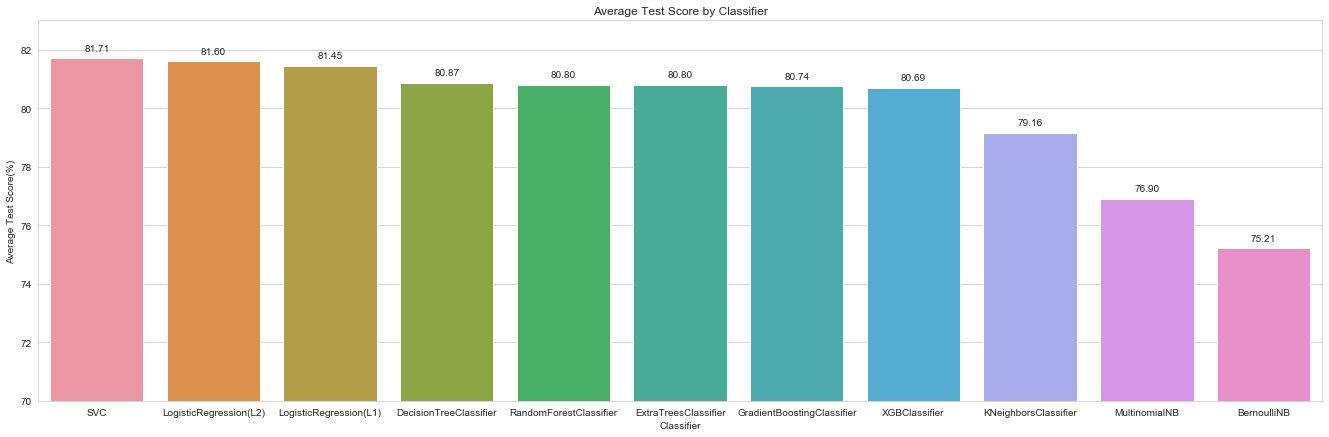

In [83]:
sns.set_style('whitegrid')
plt.figure(figsize=(23,7))
splot = sns.barplot('Classifier', 'Average Test Score(%)', data=holdout_inc_stats.sort_values('Average Test Score(%)', ascending=False))
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
splot.set(ylim=(70, 83))
plt.title('Average Test Score by Classifier')
plt.show()

*Note: the figure above's lower y-axis limit is 70%, to show a more pronounced comparison.*

SVC and logistic regression perform best here (SVC with a linear kernel is basically logistic regression).

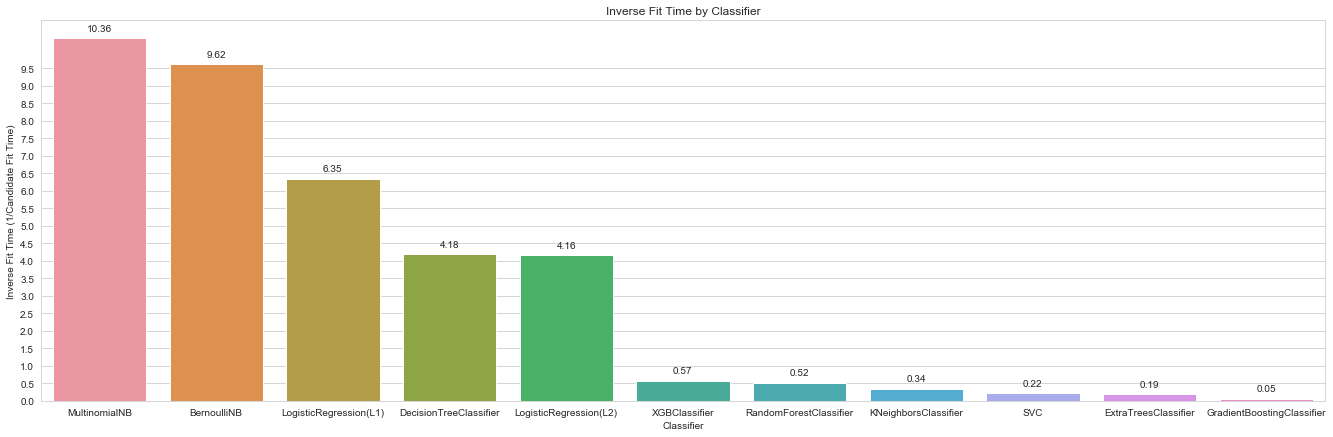

In [84]:
plt.figure(figsize=(23,7))
splot = sns.barplot('Classifier', 'Inverse Fit Time (1/Candidate Fit Time)', data=holdout_inc_stats.sort_values('Inverse Fit Time (1/Candidate Fit Time)', ascending=False))
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
splot.set(yticks=np.arange(0,10,.5))
plt.title('Inverse Fit Time by Classifier')
plt.show()

The Gradient Trees Boosting model turns out to be the slowest model of them all! Of the more complicated models, eXtreme Gradient Boosting performed the best when it comes to fitting time, which isn't too shabby as it has a pretty good accuracy score. The speed of Naive Bayes probably cannot be beat, but it does not have a very good accuracy score, relatively speaking. Logistic regression is definitely on the faster end of things.

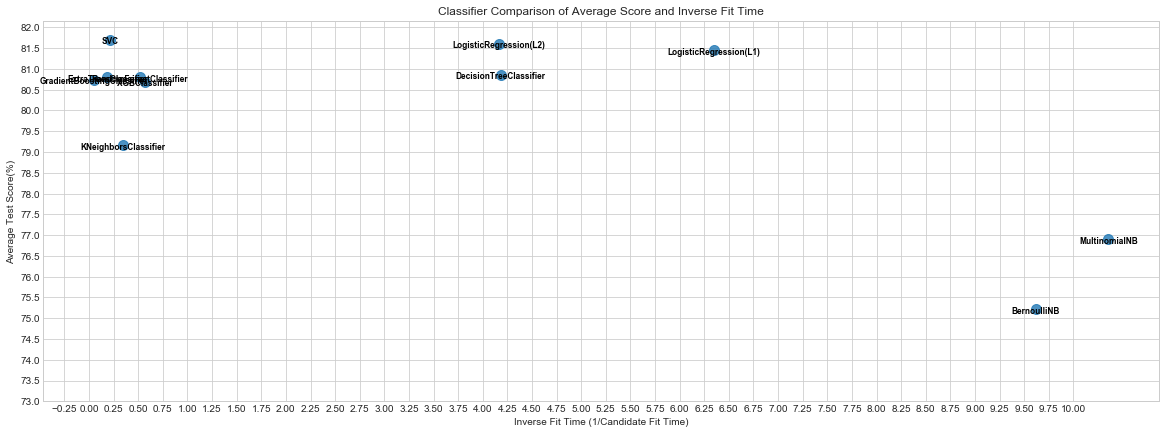

In [85]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,7))
scatter = sns.regplot(data=holdout_inc_stats, x='Inverse Fit Time (1/Candidate Fit Time)', y='Average Test Score(%)', fit_reg=False, marker='.', scatter_kws={'s':400})

for line in np.arange(0, holdout_inc_stats.shape[0]):
    scatter.text(holdout_inc_stats['Inverse Fit Time (1/Candidate Fit Time)'][line], holdout_inc_stats['Average Test Score(%)'][line]-.1, holdout_inc_stats.Classifier[line], horizontalalignment='center', size='small', color='black', weight='semibold')

scatter.set(xticks=np.arange(-.25,10.25,.25))
scatter.set(yticks=np.arange(73, 82.5,.5))

plt.title('Classifier Comparison of Average Score and Inverse Fit Time')
plt.show()

The above graph compares every model by terms of its Average Test Scores and its Inverse Fit Time. The higher up the model on the y-axis, the higher the accuracy while the further to the right on the x-axis, the faster the model. Optimally, there would be a model toward the top right corner (indicating high speed and accuracy), instead there seems to be three general groups of models:
1. Slow with decent accuracy (the group of 6 in the upper left corner)
2. Fast with decent accuracy (the middle 3)
3. Extremely fast but relatively bad accuracy (the two Naive Bayes models)

Choosing a model is pretty easy in this case, we'll take one of the best in accuracy with fast speed in Logistic Regression (L2).

# THE WINNER: Logistic Regression (L2)

With over 1000 models trained and tested, good old Logistic Regression reigns supreme.

The exact parameters for the model are as follows:

In [86]:
only_est[0]

LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

The data scaling type is as follows:

In [87]:
scalers['logistic']

'standardized'

The reasoning for this selection can be surmised from the above, but essentially Logistic Regression (L2) is very fast and also accurate.

# Quick Recap

Took the features obtained from the prior data cleaning and exploration notebook and found the optimal model to use on those features.

Next step, [NBA Model Testing](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/supervised_capstone/Jupyter%20Notebooks/Model_Testing.ipynb).

For navigational convenience:
1. [NBA Data Aggregation](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/supervised_capstone/Jupyter%20Notebooks/Data_Aggregation.ipynb)
2. [NBA Data Cleaning and Exploration](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/supervised_capstone/Jupyter%20Notebooks/Data_Cleaning_Exploration.ipynb)
3. [NBA Modeling](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/supervised_capstone/Jupyter%20Notebooks/Modeling.ipynb)*
4. [NBA Model Testing](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/supervised_capstone/Jupyter%20Notebooks/Model_Testing.ipynb)